In [1]:
import pandas as pd
import numpy as np
import cv2 as cv

import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import cv2

img = cv2.imread('fer2013Balanced/train/Anger/0_31x31_Training.jpg')

# dimensions
height, width, channels = img.shape
print(f'Dimensions: {width}x{height}')

Dimensions: 48x48


In [3]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

fer_training_data = train_data_generator.flow_from_directory(
    'fer2013Balanced/train',
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    classes=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
)

fer_training_data

Found 23251 images belonging to 7 classes.


In [4]:
test_data_generator = ImageDataGenerator(rescale=1./255)
fer_test_data = test_data_generator.flow_from_directory(
    'fer2013Balanced/test',
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    classes=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
)
fer_test_data

Found 5772 images belonging to 7 classes.


In [5]:
import tensorflow.keras as keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall  # Importar las métricas

# Cargar la base de ResNet50 sin la parte superior (sin las capas de clasificación)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Congelar las primeras capas de ResNet50
for layer in resnet_base.layers[:-10]: 
    layer.trainable = False

# Agregar las capas superiores para la clasificación
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dropout(0.5)(x)
output_tensor = Dense(7, activation='softmax')(x)  # Suponiendo que tienes 7 clases de salida

# Crear el modelo
model = Model(inputs=resnet_base.input, outputs=output_tensor)

# Compilar el modelo con precisión, recall y accuracy
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [6]:
from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

def channel_attention(input_feature, ratio=8):
    channel_axis = -1 if K.image_data_format() == 'channels_last' else 1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = add([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    return multiply([input_feature, cbam_feature])


from keras.layers import Lambda

def spatial_attention(input_feature):
    kernel_size = 7

    # Use tf.keras.backend.mean instead of directly calling K.mean
    avg_pool = Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return Multiply()([input_feature, cbam_feature])


def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521."""
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply

def se_block(input_feature, ratio=16):
    """Create a Squeeze-and-Excitation block."""
    channel_axis = -1 if K.image_data_format() == 'channels_last' else 1
    channels = input_feature.shape[channel_axis]
    se_shape = (1, 1, channels)

    se = GlobalAveragePooling2D()(input_feature)
    se = Reshape(se_shape)(se)
    se = Dense(channels // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    return multiply([input_feature, se])

In [7]:
from tensorflow.keras.layers import Multiply
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, add, Permute, Concatenate, Attention
from keras.layers import Activation, Lambda, AveragePooling2D
from keras import backend as K

input_tensor = Input(shape=(48, 48, 1))

# Convolutional Block 1
x = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = se_block(x)
x = cbam_block(x)  # CBAM block


# Convolutional Block 2 
x = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# Convolutional Block 3
x = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = se_block(x)
x = cbam_block(x)  # CBAM block


# Convolutional Block 4 
x = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# Convolutional Block 5
x = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = se_block(x )
x = cbam_block(x)  # CBAM block 


# Convolutional Block 6
x = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# Final layers 
x = Flatten()(x)
x = Dense(256, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
output_tensor = Dense(7, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

from tensorflow.keras.metrics import Precision, Recall

# Compilar el modelo con las métricas de precisión y recall
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 256)  2560        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 256)  1024       ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 256)         0           ['batch_normalization[0][0]

In [8]:
from tensorflow.keras import optimizers
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

In [9]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [10]:
history = model.fit(
    fer_training_data,
    epochs=60, 
    validation_data=fer_test_data,
    batch_size = 128,
    callbacks=callbacks,
)

Epoch 1/60
364/364 [==============================] - 182s 471ms/step - loss: 1.8340 - accuracy: 0.3235 - precision: 0.4811 - recall: 0.1329 - val_loss: 1.5140 - val_accuracy: 0.4274 - val_precision: 0.6522 - val_recall: 0.2587 - lr: 0.0010
Epoch 2/60
364/364 [==============================] - 100s 275ms/step - loss: 1.3332 - accuracy: 0.4989 - precision: 0.6663 - recall: 0.3161 - val_loss: 1.5081 - val_accuracy: 0.5059 - val_precision: 0.5640 - val_recall: 0.4297 - lr: 0.0010
Epoch 3/60
364/364 [==============================] - 103s 282ms/step - loss: 1.1063 - accuracy: 0.5900 - precision: 0.7157 - recall: 0.4473 - val_loss: 1.2329 - val_accuracy: 0.5589 - val_precision: 0.6760 - val_recall: 0.4331 - lr: 0.0010
Epoch 4/60
364/364 [==============================] - 102s 280ms/step - loss: 0.9349 - accuracy: 0.6493 - precision: 0.7546 - recall: 0.5344 - val_loss: 1.2509 - val_accuracy: 0.5513 - val_precision: 0.6784 - val_recall: 0.4430 - lr: 0.0010
Epoch 5/60
364/364 [================

In [12]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(fer_test_data)
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test precision: {test_precision:.2f}")
print(f"Test recall: {test_recall:.2f}")

91/91 [==============================] - 8s 91ms/step - loss: 0.4356 - accuracy: 0.8472 - precision: 0.8652 - recall: 0.8297
Test accuracy: 0.85
Test precision: 0.87
Test recall: 0.83


In [13]:
import numpy as np

# Obtener predicciones del modelo
y_true = fer_test_data.classes  # Etiquetas reales del conjunto de prueba
y_pred = model.predict(fer_test_data)  # Probabilidades predichas
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades en clases

91/91 [==============================] - 7s 71ms/step


In [22]:
model.save('tesis_modelo.h5')
model.save('tesis_modelo.keras')


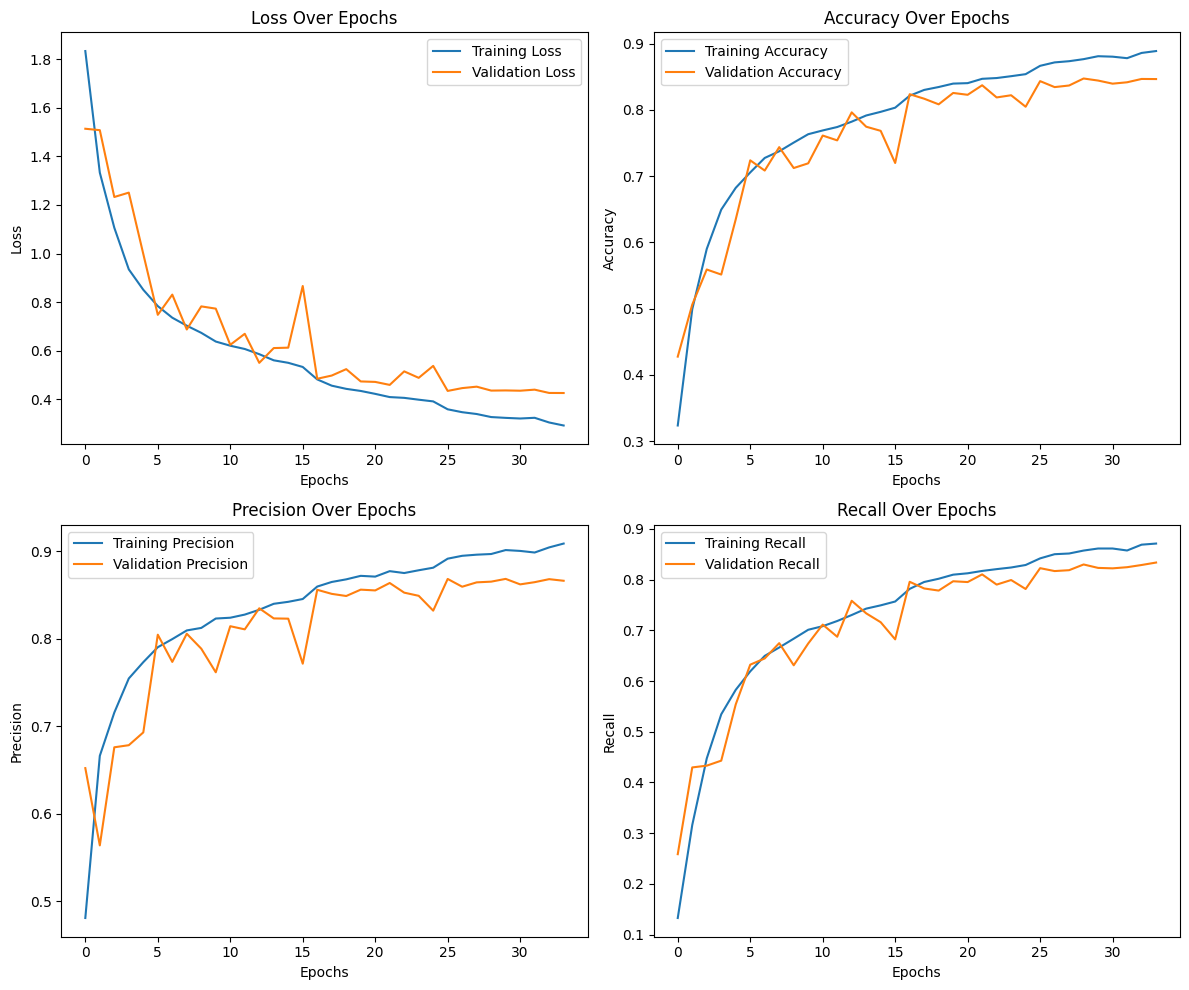

In [15]:
import matplotlib.pyplot as plt

# Extraer los valores de historial
history_dict = history.history

# Crear una figura para los subgráficos
plt.figure(figsize=(12, 10))

# Histograma de Loss
plt.subplot(2, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Histograma de Accuracy
plt.subplot(2, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Histograma de Precision
plt.subplot(2, 2, 3)
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Histograma de Recall
plt.subplot(2, 2, 4)
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall')
plt.title('Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()


In [16]:
print(fer_test_data.class_indices)


{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [17]:
print(fer_training_data.class_indices)


{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [18]:
print("Clases presentes en los datos de prueba:", fer_test_data.class_indices)
print("Número de clases presentes en los datos de prueba:", len(fer_test_data.class_indices))

Clases presentes en los datos de prueba: {'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
Número de clases presentes en los datos de prueba: 7


In [21]:

from sklearn.metrics import classification_report

# Generar predicciones
predictions = model.predict(fer_test_data)

# Convertir las predicciones de probabilidades a etiquetas de clase
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales
true_classes = fer_test_data.classes

# Obtener las etiquetas de las clases
class_labels = list(fer_test_data.class_indices.keys())

# Generar el reporte de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)

# Imprimir el reporte de clasificación con estadísticas detalladas por cada emoción
print("Classification Report:\n")
print(report)

91/91 [==============================] - 6s 70ms/step
Classification Report:

              precision    recall  f1-score   support

       Anger     0.1414    0.1473    0.1443       828
     Disgust     0.1333    0.1284    0.1308       841
        Fear     0.1615    0.1567    0.1591       836
       Happy     0.1397    0.1273    0.1332       833
     Neutral     0.1458    0.1675    0.1559       806
         Sad     0.1627    0.1541    0.1583       798
    Surprise     0.1381    0.1410    0.1395       830

    accuracy                         0.1459      5772
   macro avg     0.1461    0.1460    0.1459      5772
weighted avg     0.1460    0.1459    0.1457      5772



In [37]:
from mtcnn import MTCNN
import cv2
import numpy as np
from tensorflow.keras.models import load_model  # Asumiendo que el modelo es un modelo de Keras

# Lista de emociones (asegúrate de que esta lista esté definida de acuerdo con el orden de salida de tu modelo)
EMOTIONS = ["anger", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Cargar tu modelo (ajusta la ruta según el lugar donde esté almacenado tu modelo)
model = load_model('tesis_modelo.keras')

def detect_faces_emo(image_path, detection_confidence=0.9, min_face_size=30):
    # Cargar la imagen usando OpenCV
    image = cv2.imread(image_path)
    
    # Convertir la imagen a RGB para MTCNN
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Crear una instancia del detector MTCNN
    detector = MTCNN()

    # Detectar las caras en la imagen
    faces = detector.detect_faces(image_rgb)

    # Verificar si se han detectado caras
    if len(faces) == 0:
        print("No se detectaron caras.")
        return

    # Procesar cada cara detectada
    for face in faces:
        if face['confidence'] < detection_confidence:
            continue
        
        # Extraer las coordenadas del cuadro delimitador
        x, y, width, height = face['box']
        
        # Verificar el tamaño mínimo de la cara
        if min(width, height) < min_face_size:
            continue
        
        # Extraer la región de la cara de la imagen
        face_image = image[y:y+height, x:x+width]
        
        # Convertir la imagen de la cara a escala de grises
        face_image_gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
        
        # Redimensionar la imagen de la cara a 48x48
        face_image_resized = cv2.resize(face_image_gray, (48, 48))
        
        # Normalizar la imagen para que coincida con el formato de entrada del modelo
        face_image_resized = face_image_resized / 255.0
        
        # Redimensionar para agregar una dimensión de canal
        face_image_reshaped = face_image_resized.reshape((1, 48, 48, 1))

        # Predecir la emoción de la cara
        predicted_emo = model.predict(face_image_reshaped)[0]
        
        # Ordenar las emociones por probabilidad
        predicted_emo_sorted = sorted(list(enumerate(predicted_emo)), key=lambda x: x[1], reverse=True)
        
        # Obtener la probabilidad de las emociones
        probabilities = ["{}: {}%".format(EMOTIONS[index], round(prob * 100)) for index, prob in predicted_emo_sorted]

        # Clasificación de la emoción como "atento" o "desatento"
        label = EMOTIONS[np.argmax(predicted_emo)]
        if label in ['happy', 'surprise', 'neutral']:
            attention_status = 'Atento'
            color = (0, 255, 0)  # Verde para atento
        else:
            attention_status = 'Desatento'
            color = (0, 0, 255)  # Rojo para desatento

        # Dibujar el estado de atención por encima de la emoción, más arriba y con letras rojas
        cv2.putText(image, f"Estado: {attention_status}", (x, y - 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Dibujar el cuadro alrededor de la cara y las emociones
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.8, color, 3)
        
        # Dibujar el rectángulo alrededor de la cara
        cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)

        # Dibujar las probabilidades de emociones
        table_x, table_y = x + 10, y + height + 20
        for prob in probabilities:
            cv2.putText(image, prob, (table_x, table_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            table_y += 40

    # Guardar la imagen con las emociones detectadas
    output_image_path = "detected_faces_with_emo.jpg"
    cv2.imwrite(output_image_path, image)

    # Retornar la ruta de la imagen procesada
    return output_image_path


In [38]:
import os

INPUT_PATH = 'fer2013/test'
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (48, 48)

print(EMOTIONS)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


1/1 [==============================] - 0s 40ms/step


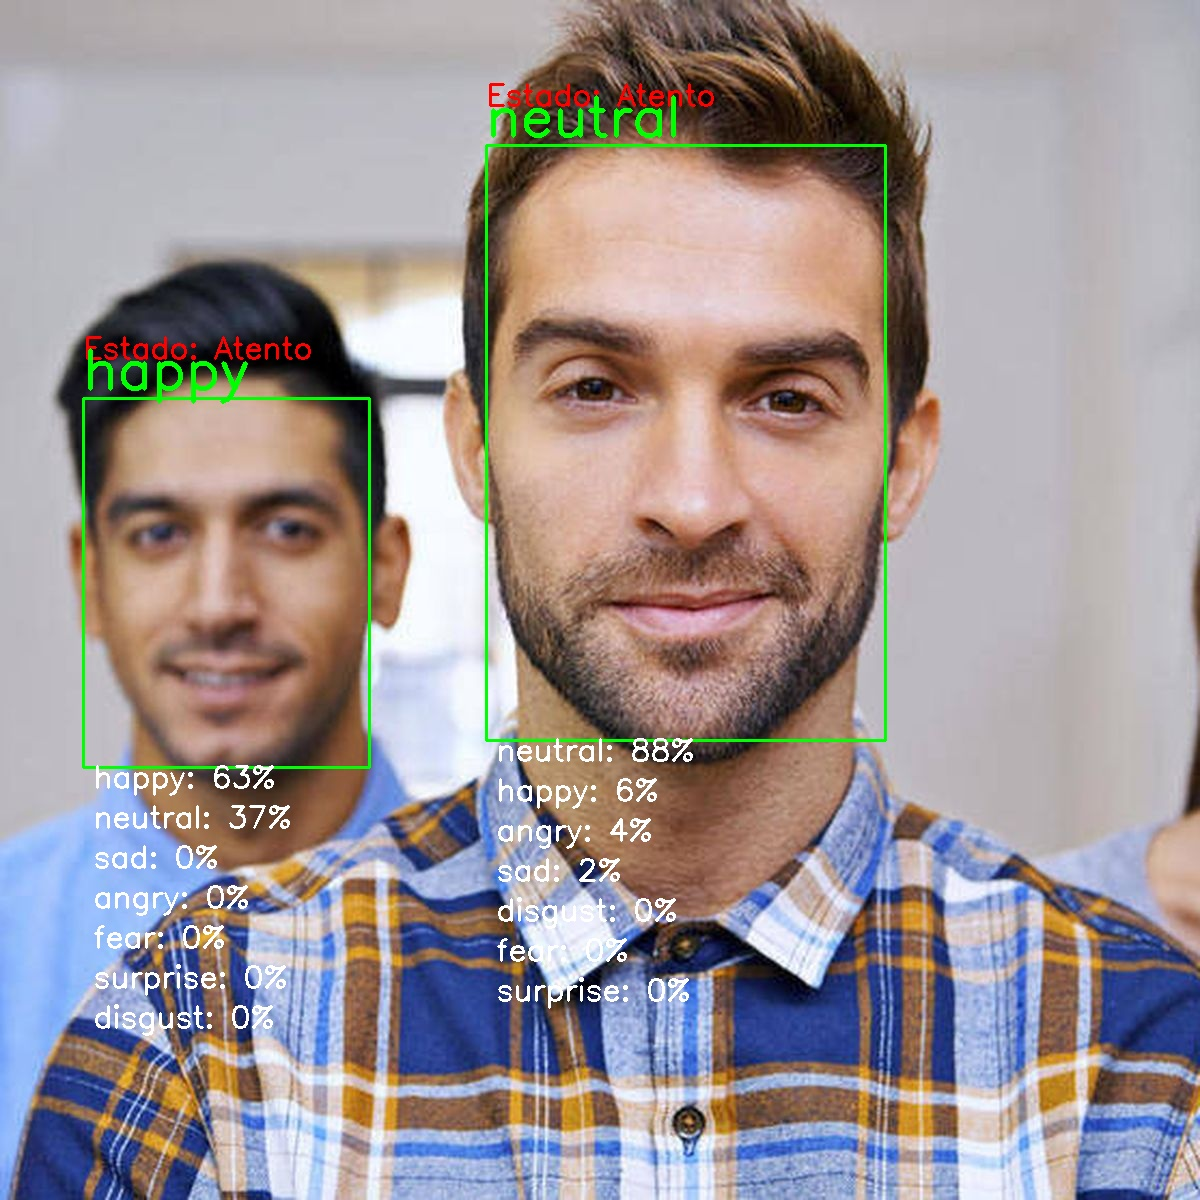

In [39]:
from IPython.display import Image
# Detect faces in the new image of my friends and save the result to a file
image_path = detect_faces_emo('14.jpg')
# Display the saved image
Image(filename=image_path)